<a href="https://colab.research.google.com/github/Lanxin-Xiang/is765/blob/main/W5a_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W5a. Classification

Ref:

https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/tensorboard_in_notebooks.ipynb

https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/get_started.ipynb#scrollTo=Q3nupQL24E5E

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

https://fasttext.cc/docs/en/supervised-tutorial.html

https://towardsdatascience.com/fasttext-for-text-classification-a4b38cbff27c

## Classification task with LSTM

We will use a [sentiment classification dataset on UCI](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) to illustrate how to implement a lstm deep learning model with logit classifier. Download this dataset and import it with code below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True)

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/is765

/content/drive/MyDrive/is765


In [35]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from pprint import pprint
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import datetime
import math

In [ ]:
!wget -nc -P data/ https://archive.ics.uci.edu/static/public/331/sentiment+labelled+sentences.zip # -nc skip if files exist
!unzip -n data/sentiment+labelled+sentences.zip -d data/ # -n skip if files exist

File ‘data/sentiment+labelled+sentences.zip’ already there; not retrieving.

Archive:  data/sentiment+labelled+sentences.zip


Create two numpy arrays to store the texts and labels separately.

In [36]:
text = []
label = []
for line in open("data/sentiment labelled sentences/yelp_labelled.txt"):
    line = line.rstrip('\n').split('\t')
    text.append(line[0])
    label.append(int(line[1]))
text = np.array(text)
label = np.array(label)

In [37]:
num_print = 10
print(np.hstack((text[:num_print].reshape(num_print,1), label[:num_print].reshape(num_print,1))))

[['Wow... Loved this place.' '1']
 ['Crust is not good.' '0']
 ['Not tasty and the texture was just nasty.' '0']
 ['Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.'
  '1']
 ['The selection on the menu was great and so were the prices.' '1']
 ['Now I am getting angry and I want my damn pho.' '0']
 ["Honeslty it didn't taste THAT fresh.)" '0']
 ['The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.'
  '0']
 ['The fries were great too.' '1']
 ['A great touch.' '1']]


Split the dataset. Set 20% of the data as validation data.

In [44]:
X_train, X_test, y_train, y_test = train_test_split(text, label, test_size=0.2, random_state=42)

Here we use the `TextVectorization()` function in `keras` to complete basic text processing tasks. See the function documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization). In particular, you can control the following things:
- tokenization (split)
- lowercasing and remove puctuation (standardize)
- optionally generate ngrams
- turn into integer representation (output_mode = 'int')
- whether to pad texts of different length to the same sequence length (output_sequence_length)

In [38]:
vectorize_layer = keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens = None,
    standardize = 'lower_and_strip_punctuation',
    split = 'whitespace',
    ngrams = None,
    output_mode = 'int',
    output_sequence_length = None
)

In [39]:
# apply it to the text data with "adapt"
vectorize_layer.adapt(text)

In [ ]:
# check preprocessing results, such as vocabulary,
vectorize_layer.get_vocabulary()

In [41]:
len(vectorize_layer.get_vocabulary())

2082

Note that the vocabulary contains two special tokens:
- ' ' is called the **padding token**. It is an empty string, correspond to index 0, that can be used to pad texts of different lengths to the same sequence length. When this text vectorization layer is applied to a set of texts, it automatically perform padding (to the longest sequence).
- '[UNK]' is called the **Out-of-Vocabulary token**. It is used to represent any word that does not appear in the vocabulary.

The next block of code is for demonstration purpose only - it is typically NOT needed in actual model building. We want to use `vectorize_layer` to process some texts and represent them as indices in vocabulary.

In [42]:
# now use it to process some text
input_text = [['very good food'], ['language model']]
vectorize_layer(input_text)

<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
array([[20, 17, 12],
       [ 1,  1,  0]])>

We will demostrate how to use both `tensorboard` and `matplotpy` to visualize the training process. Unlike plotting loss and accuracy with history object, we need to specify our logging directory with callbacks when compiling models.

In [ ]:
# install tensorboard if needed

!pip install tensorboard

In [ ]:
# load tensorboard for later analysis.
%load_ext tensorboard

In [46]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")) # specify log directory

model = Sequential()
model.add(vectorize_layer)
model.add(Embedding(
    input_dim = len(vectorize_layer.get_vocabulary()),
    output_dim = 64,
    mask_zero = True
))
model.add(LSTM(64, return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

checkpoint_callback = ModelCheckpoint(filepath= '/tmp/checkpoint', monitor="val_accuracy", save_best_only=True)
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystopping_callback = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='auto')

callbacks_list = [checkpoint_callback, tensorboard_callback, earlystopping_callback]

We reuse the model introduced in W4b by modifying the structure to complish a classification task. Because we only need a single output at the end of the entire LSTM, we only need to specify the total number of LSTM units in the `LSTM` function.

In [47]:
# configure training / optimization
opt = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss = keras.losses.BinaryCrossentropy(),
                  optimizer=opt,
                  metrics=['accuracy'])

In [48]:
# training with 20% validation and 20 epochs.
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=20,
                    batch_size=32, callbacks=[checkpoint_callback, tensorboard_callback])

Epoch 1/20
25/25 [==============================] - 59s 2s/step - loss: 0.6216 - accuracy: 0.6375 - val_loss: 0.5205 - val_accuracy: 0.7650
Epoch 2/20
25/25 [==============================] - 32s 1s/step - loss: 0.2158 - accuracy: 0.9237 - val_loss: 0.5384 - val_accuracy: 0.7900
Epoch 3/20
25/25 [==============================] - 2s 83ms/step - loss: 0.0842 - accuracy: 0.9700 - val_loss: 0.8519 - val_accuracy: 0.7800
Epoch 4/20
25/25 [==============================] - 22s 926ms/step - loss: 0.0311 - accuracy: 0.9912 - val_loss: 0.8317 - val_accuracy: 0.7950
Epoch 5/20
25/25 [==============================] - 2s 94ms/step - loss: 0.0104 - accuracy: 0.9975 - val_loss: 1.3130 - val_accuracy: 0.7650
Epoch 6/20
25/25 [==============================] - 2s 89ms/step - loss: 0.0070 - accuracy: 0.9987 - val_loss: 1.3081 - val_accuracy: 0.7850
Epoch 7/20
25/25 [==============================] - 2s 89ms/step - loss: 0.0086 - accuracy: 0.9962 - val_loss: 1.0684 - val_accuracy: 0.7650
Epoch 8/20
25

**Visualize with plt**

Text(0.5, 1.0, 'Accuracy Curves')

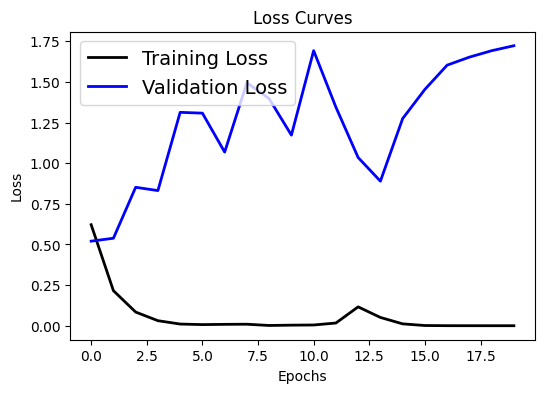

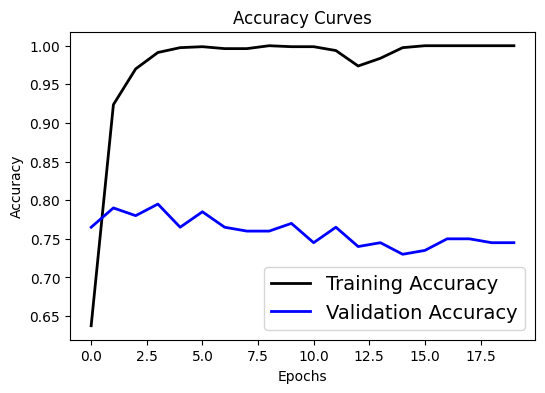

In [50]:
# Plotting the loss curve
plt.figure(figsize=[6,4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'blue', linewidth=2.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.title('Loss Curves', fontsize=12)

# Plotting the accuracy curve
plt.figure(figsize=[6,4])
plt.plot(history.history['accuracy'], 'black', linewidth=2.0)
plt.plot(history.history['val_accuracy'], 'blue', linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.title('Accuracy Curves', fontsize=12)

**Use tensorboard to visualize training process**

Load tensorboard with logging data.

You might encounter **403** problem when loading tensorboard. Two possible solutions:

1. Allow third-party coockies on your browser. For chrome users: chrome://settings/cookies

2. Run the `tensorboard dev upload` code |bellow to log in google account and varify identity.

You can find more about how to use tensorboard with Colab [here](https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/get_started.ipynb#scrollTo=Q3nupQL24E5E)!

In [ ]:
%tensorboard --logdir logs

In [ ]:
# upload tensorboard

!tensorboard dev upload \
  --logdir logs/ \
  --name "(optional) My latest experiment" \
  --description "(optional) Simple comparison of several hyperparameters" \
  --one_shot

2023-09-28 18:44:53.187059: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/CdtOVrWyTkeGUOdRaKzFGQ/

[2023-09-28T18:44:55] Started scanning logdir.
E0928 18:44:56.790647 139091359760384 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
E0928 18:44:59.784396 139091359760384 uploader.py:1122] Attempted to re-upload existing blob.  Skipping.
[2023-09-28T18:45:01] Total uploaded: 564 scalars, 0 tensors, 4 binary objects (2.8 MB)
Total skipped: 2 binary objects (1.1 MB)
[2023-09-28T18:45:01] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/CdtOVrWyTkeGUOdRaKzFGQ/


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, None)              0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, None, 64)          133248    
                                                                 
 lstm (LSTM)                 (None, None, 64)          33024     
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

In [ ]:
model.save('lstm.classification.keras')

In [ ]:
# try to make some predicitons
model.predict([['I hate this meal!'], ['I love this restaurant']])

1/1 [==============================] - 3s 3s/step


array([[0.8484372],
       [0.9999966]], dtype=float32)

## Classification with FastText

In [1]:
from google.colab import drive
drive.mount('/content/drive') #, force_remount=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/is765

/content/drive/MyDrive/is765


### Install fasttext

In [3]:
!wget -nc https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip -n v0.9.2.zip

File ‘v0.9.2.zip’ already there; not retrieving.

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe


In [4]:
%cd fastText-0.9.2

/content/drive/MyDrive/is765/fastText-0.9.2


In [5]:
!make
!pip install .

make: Nothing to be done for 'opt'.
Processing /content/drive/MyDrive/is765/fastText-0.9.2
  Preparing metadata (setup.py) ... done
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4199749 sha256=ebbeedd1427c6cddd30a0ce6f47a9b128f705957ec7701647eb82293ce28b988
  Stored in directory: /root/.cache/pip/wheels/25/1b/0b/76cee6473d07bdc0856c74561d5269c877458db0223f867955
Successfully built fasttext
  Attempting uninstall: fasttext
    Found existing installation: fasttext 0.9.2
    Uninstalling fasttext-0.9.2:
      Successfully uninstalled fasttext-0.9.2


In [6]:
%cd ..

/content/drive/MyDrive/is765


In [7]:
import fasttext

In [ ]:
help(fasttext.FastText)

### Prepare data

In this tutorial, we are interested in building a classifier to automatically recognize the topic of a stackexchange question about cooking. Let's download examples of questions from the cooking section of Stackexchange, and their associated tags.

Each line of the text file contains a list of labels, followed by the corresponding document. All the labels start by the `__label__` prefix, which is how `fastText` recognize what is a label or what is a word. The model is then trained to predict the labels given the word in the document.

In [9]:
!wget https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz && tar xvzf cooking.stackexchange.tar.gz

--2023-09-29 15:07:23--  https://dl.fbaipublicfiles.com/fasttext/data/cooking.stackexchange.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.19, 3.162.163.11, 3.162.163.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 457609 (447K) [application/x-tar]
Saving to: ‘cooking.stackexchange.tar.gz’

cooking.stackexchan 100%[===================>] 446.88K  --.-KB/s    in 0.06s   

2023-09-29 15:07:23 (7.55 MB/s) - ‘cooking.stackexchange.tar.gz’ saved [457609/457609]

cooking.stackexchange.id
cooking.stackexchange.txt
readme.txt


In [11]:
!head cooking.stackexchange.txt

__label__sauce __label__cheese How much does potato starch affect a cheese sauce recipe?
__label__food-safety __label__acidity Dangerous pathogens capable of growing in acidic environments
__label__cast-iron __label__stove How do I cover up the white spots on my cast iron stove?
__label__restaurant Michelin Three Star Restaurant; but if the chef is not there
__label__knife-skills __label__dicing Without knife skills, how can I quickly and accurately dice vegetables?
__label__storage-method __label__equipment __label__bread What's the purpose of a bread box?
__label__baking __label__food-safety __label__substitutions __label__peanuts how to seperate peanut oil from roasted peanuts at home?
__label__chocolate American equivalent for British chocolate terms
__label__baking __label__oven __label__convection Fan bake vs bake
__label__sauce __label__storage-lifetime __label__acidity __label__mayonnaise Regulation and balancing of readymade packed mayonnaise and other sauces


In [13]:
!wc cooking.stackexchange.txt

  15404  169582 1401900 cooking.stackexchange.txt


Before training our first classifier, we need to split the data into train and validation. We will use the validation set to evaluate how good the learned classifier is on new data.

In [14]:
!head -n 12404 cooking.stackexchange.txt > cooking.train
!tail -n 3000 cooking.stackexchange.txt > cooking.valid

### Train a classifier

In [16]:
ft_model = fasttext.train_supervised(input="cooking.train")

In [17]:
ft_model.save_model("ft_classification_cooking.bin")

In [19]:
ft_model.predict("Which baking dish is best to bake a banana bread ?")

(('__label__baking',), array([0.07257967]))

In [21]:
ft_model.predict("Why not put knives in the dishwasher?")

(('__label__food-safety',), array([0.07451777]))

The output are the number of samples (here 3000), the precision at one (0.135) and the recall at one (0.0584).

In [22]:
ft_model.test("cooking.valid")

(3000, 0.135, 0.05838258613233386)

Here is the results of the precision at five and recall at five with:

In [23]:
ft_model.test("cooking.valid", k=5)

(3000, 0.06606666666666666, 0.14285714285714285)

### Different ways to enhance the performance

**Preprocessing data**

In [24]:
!cat cooking.stackexchange.txt | sed -e "s/\([.\!?,'/()]\)/ \1 /g" | tr "[:upper:]" "[:lower:]" > cooking.preprocessed.txt
!head -n 12404 cooking.preprocessed.txt > cooking.train
!tail -n 3000 cooking.preprocessed.txt > cooking.vali

In [25]:
ft2 = fasttext.train_supervised(input="cooking.train")

In [26]:
ft2.test("cooking.valid")

(3000, 0.155, 0.06703185815193888)

**More epoch**

In [27]:
ft3 = fasttext.train_supervised(input="cooking.train", epoch=25)

In [28]:
ft3.test("cooking.valid")

(3000, 0.41733333333333333, 0.18048147614242468)

**Try different learning rates**

In [31]:
ft4 = fasttext.train_supervised(input="cooking.train", lr=1.0, epoch=25)

In [32]:
ft4.test("cooking.valid")

(3000, 0.479, 0.20715006486954016)

**word n-grams**

In [33]:
ft5 = fasttext.train_supervised(input="cooking.train", lr=1.0, epoch=25, wordNgrams=2)

In [34]:
ft5.test("cooking.valid")

(3000, 0.493, 0.21320455528326365)

### Train a fastText classifier on our previous sentiment data

In [56]:
import pandas as pd

In [57]:
train_size = len(X_train)
test_size = len(X_test)

In [58]:
sent_train_array = np.hstack((y_train.reshape(train_size,1), X_train.reshape(train_size,1)))
sent_test_array = np.hstack((y_test.reshape(test_size,1), X_test.reshape(test_size,1)))

In [59]:
sent_train_df = pd.DataFrame(sent_train_array, columns = ['label','text'])
sent_test_df = pd.DataFrame(sent_test_array, columns = ['label','text'])

In [71]:
sent_train_df['label'] = sent_train_df['label'].apply(lambda x: '__label__' + x)
sent_test_df['label'] = sent_test_df['label'].apply(lambda x: '__label__' + x)

In [72]:
sent_train_df.to_csv('data/sent_train.txt', index = False, sep = ' ', header = None)
sent_test_df.to_csv('data/sent_test.txt', index = False, sep = ' ', header = None)

In [74]:
ft_sent = fasttext.train_supervised('data/sent_train.txt', epoch=20)

In [75]:
ft_sent.test('data/sent_test.txt')

(200, 0.755, 0.755)

In [82]:
test_sample = sent_test_df.iloc[23, 1]
print(ft_sent.predict(test_sample),)
print(test_sample)

(('__label__1',), array([0.54308963]))
Be sure to order dessert, even if you need to pack it to-go - the tiramisu and cannoli are both to die for.


Compare these two models' results, for this dataset, the performances are similar. However, the training time of fastTaxt is much shorter.